In [4]:
%matplotlib inline
import sys
import pandas as pd
import math
import matplotlib.pylab as plt
import matplotlib as mpl
from collections import Counter
import numpy as np
import subprocess
import re
import itertools
import mmh3
import json
import pickle
from datetime import datetime as dt
from datetime import time
from random import randrange, gauss, shuffle

In [12]:
def network_reformat_multiplex(layers, halflife=-1):
    """Return multiplex representation of multiplex network
    
    Parameters
    ----------
    halflife : number
        Halflife in seconds of relax-rate decay between layers.
        Defaults to -1.
    layers : pandas df formatted layers
        
    Returns
    -------
    net_file : string
        A network string in multiplex format
    int_to_hash : dict
        Key-value pairs of node integer id and original hash id
    """
    
    # Infomap will only work with node ids as indices.
    
    # Get all node ids in original md5 hash values
    nodes = set()
    for l, df in enumerate(layers):
        layer_nodes = set()
        layer_nodes.update(df["user1"])
        layer_nodes.update(df["user2"])
        nodes.update(layer_nodes)
        
    
    ##########################
    ## Add vertices to file ##
    ##########################
    
    out_file = "*Vertices %d" % len(nodes)
    
    # Node name book-keeping, and adding to file
    hashid_to_intid = {}
    intid_to_hashid = {}
    for i,n in enumerate(nodes):
        intid = i+1
        hashid = str(n)
        out_file += '\n%d "Node %s" 1.0' % (intid,hashid)
        hashid_to_intid[hashid] = intid
        intid_to_hashid[intid] = hashid

        
    #############################
    ## Add Intra-edges to file ##
    #############################
    
    out_file += "\n*Multiplex\n# Intra edges: layer node layer node weight"
    
    for l, df in enumerate(layers):
        user1 = df["user1"]
        user2 = df["user2"]
            
        edges = zip(user1, user2)
        
        # Add weights. REDUNDANT FOR 5MINS TIMESLICES BECAUSE PPL ONLY MEET ONCE HERE.
        edges = [(e[0],e[1],w) for e,w in Counter(edges).items()]
        
        # Add Intra-edges to file
        for i,j,w in edges:
            out_file += '\n%d %s %d %s %d' % (l+1,hashid_to_intid[i], l+1,hashid_to_intid[j],w) #+1 because 1 is first layer index
            
    
    #############################
    ## Add Inter-edges to file ##
    #############################
    
    out_file += "# Intra edges: layer node layer node weight"
    
    # Infinte halflife (represented as -1)
    if halflife == -1:
        return out_file
    
    
    # Relax decay function
    def N(t):
        tau = halflife/np.log(2)
        return np.exp(-t/float(tau))
    
                        
    for l1, df1 in enumerate(layers):
        nodes1 = set(list(df1['user1'].values)+list(df1['user2'].values))
        for l2, df2 in enumerate(layers):    
            if not l2 > l1:
                continue   
            
            nodes2 = set(list(df2['user1'].values)+list(df2['user2'].values))
            common_nodes = nodes1 & nodes2
            time_diff = df2['timestamp'].values[0] - df1['timestamp'].values[0]
            
            for n in common_nodes:
                out_file += '\n%d %s %d %s %f' % (l1+1,hashid_to_intid[n],l2+1,hashid_to_intid[n],N(time_diff))
    
    
    return out_file, intid_to_hashid



def community_detection_multiplex(layers, halflife=2400, extended=True, keys="d3_ready"):
    """Run multiplex community detection because Python implementation has no docs
    
    Parameters
    ----------
    halflife : number
        Halflife in seconds of relax-rate decay between layers.
        Defaults to -1.
    layers : layers (pandas dfs)
    
    Returns
    -------
    communities : list of lists
    """
    print "-> community_detection_multiplex\n\t",
    
    def parse_communities():
        with open('output/'+multiplex_network_filename+".clu", 'r') as infile:
            multiplex_network_clusters = infile.read()

        # Get nodes, clusters and flow from .clu file
        no_clu_flo = re.findall(r'\d+ \d+ \d.\d+', multiplex_network_clusters) # ["30 1 0.00800543",...]
        no_clu = [tuple(i.split()[:2]) for i in no_clu_flo] # [(30, 1),...]

        # Formatting
        communities = [[] for _ in [[]]*max([int(i[1]) for i in tmp2])] #Alike to [[]]*max... (trick to avoid mutability)
        for no,clu in no_clu:
            communities[int(clu)-1].append(int(no)) #-1 because j starts at 1

        # Map from node ints to node hashes
        communities_list = [[intid_to_hashid[n] for n in c] for c in communities]
        
        return communities_list
    
    
    def parse_communities_extended():
        with open('output/'+multiplex_network_filename+"_expanded.clu", 'r') as infile:
            multiplex_network_clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu = re.findall(r'\d+ \d+ \d+ \d\.\d+', multiplex_network_clusters) # ["30 1 2 0.00800543",...]
        la_no_clu = [tuple(i.split()) for i in la_no_clu]

        communities_json = {}
        for layer, node, cluster, _ in la_no_clu:
            try:
                communities_json[int(layer)].add((intid_to_hashid[int(node)], int(cluster)))
            except KeyError:
                # Will run once for every layer
                communities_json.update({int(layer): {(intid_to_hashid[int(node)], int(cluster))}})

        return communities_json
    
    
    def parse_module_flow_from_map():
        with open('output/'+multiplex_network_filename+".map", 'r') as infile:
            multiplex_network_tree = infile.read()

        # Get flow for each node from .tree file
        module_flow =  [float(j) for j in re.findall(r'0\.\d+ ', multiplex_network_tree)]
        exit_flow =  [float(j.split()[1]) for j in re.findall(r'0\.\d+ \d.+', multiplex_network_tree)]

        return module_flow, exit_flow
    

    
    # Get network in mutliplex string format and define filename
    multiplex_network, intid_to_hashid = network_reformat_multiplex(layers, halflife=halflife)
    multiplex_network_filename = 'multiplex-network'

    # Store locally
    with open("input/"+multiplex_network_filename+".net", 'w') as outfile:
        outfile.write(multiplex_network)
    
    # Run Infomap for multiplex network
    subprocess.call(['./Infomap/Infomap', 'input/'+multiplex_network_filename+".net", 
                     'output/', '-i', 'multiplex', '--overlapping', '--map', '--clu', '--tree', '--expanded'])
    

    if extended and keys == "layers":
        return parse_communities_extended()
    
    if extended and keys == "communities":
        hash_clu = [item for sublist in parse_communities_extended().values() for item in sublist]
        communities = dict()
        for key, group in itertools.groupby(hash_clu, lambda x: x[1]):
            for thing in group:
                try:
                    communities[key].append(thing[0])
                except KeyError:
                    communities[thing[1]] = [thing[0]]
        return dict((k,set(v)) for k,v in communities.items())
    
    if extended and keys == "d3_ready":
        communities = {}
        for layer, group in parse_communities_extended().items():
            layer_communities = {}
            for no, clu in group:
                try:
                    layer_communities[clu].append(no)
                except KeyError:
                    layer_communities[clu] = [no]
            communities[layer] = layer_communities
        return communities
    
    if extended and keys == "pipeline":
        hash_clu = [item for sublist in parse_communities_extended().values() for item in sublist]
        communities = dict()
        for key, group in itertools.groupby(hash_clu, lambda x: x[1]):
            for thing in group:
                try:
                    communities[key].append(thing[0])
                except KeyError:
                    communities[thing[1]] = [thing[0]]
        communities = dict((k,set(v)) for k,v in communities.items())
        
        d3_ready = {}
        for layer, group in parse_communities_extended().items():
            layer_communities = {}
            for no, clu in group:
                try:
                    layer_communities[clu].append(no)
                except KeyError:
                    layer_communities[clu] = [no]
            d3_ready[layer] = layer_communities
            
        return communities, d3_ready
        
    else:
        return parse_communities()

In [13]:
# Don't remember if I really need this code
def compute_neighbor_similarities(ordering, X):
    neighbor_similarities = [0]*len(ordering)
    for i in range(len(ordering)):
        if i == 0:
            neighbor_similarities[i] += X[ordering[i]-1, ordering[i+1]-1]
        elif i == len(ordering)-1:
            neighbor_similarities[i] += X[ordering[i]-1, ordering[i-1]-1]
        else:
            neighbor_similarities[i] += X[ordering[i]-1, ordering[i+1]-1]
            neighbor_similarities[i] += X[ordering[i]-1, ordering[i-1]-1]
            
    return neighbor_similarities

In [14]:
# To the best of my memory, I really need this code
def get_similarity(i,j,communities, count=False):
    """communities : Communities in each layer"""
    sim_counter = len(communities[i] & communities[j])
    tot_counter = len(communities[i] | communities[j])
    
    if count:
        return sim_counter / float(tot_counter), sim_counter
    else:
        return sim_counter / float(tot_counter)

def compute_similarity_matrix(communities, zero_diagonal=False, datastructure="matrix"):
    dim = len(communities)
    X = np.empty((dim,dim))
    
    if datastructure=="matrix":
        for i in range(dim):
            for j in range(dim):
                # Introduce small random noise to make all similarities distinct
                random_noise = randrange(0,10**6) / 10**12.0
                if i == j: X[i,j] = 1.0
                if i > j:
                    sim = get_similarity(i+1,j+1,communities)
                    if sim == 0: 
                        X[j,i] = 0
                    else:
                        X[j,i] = sim + random_noise
                    X[i,j] = 0

        if zero_diagonal:
            np.fill_diagonal(X,0)
            
    if datastructure=="json":
        X = {}
        for i in range(dim):
            for j in range(dim):
                sim, count = get_similarity(i+1,j+1,communities, count=True)
                try:
                    X['c'+str(i+1)].update({'c'+str(j+1): {'sim': sim, 'count': count}})
                except KeyError:
                    X['c'+str(i+1)] = {'c'+str(j+1): {'sim': sim, 'count': count}}

    return X


def sort_by_size_weighted_similarity(communities, verbose=False):
    
    # Get array of community sizes
    community_sizes = [0]*len(communities)
    for co, nos in communities.items():
        community_sizes[co-1] = len(nos)
    community_sizes = np.mat(community_sizes)
    
    # Get similarity matrix
    X = compute_similarity_matrix(communities)
    np.fill_diagonal(X,0)

    # Weigh similarity matrix with community sizes on either axis
    X = np.multiply(X,community_sizes).A

    # Find maximum value and add its associated communities to an array
    N, M = X.shape
    sorted_communities = []
    
    
    # Sort by similarity
    while True:
        
        if len(sorted_communities) >= len(communities):
            if verbose: print np.sum(X)
            break
            
        similarity = 0
        link_end = 0
        host_link = 0
        guest_link = 0
        
        left_end = 0
        right_end = -1
        
        i = 0
        while similarity == 0:
            if i > 1000:
                if verbose: print "infinte loop"
                break
            if left_end >= len(sorted_communities) / 2.0:
                if verbose: print "--> start from new max"
                abs_index = np.argmax(X)
                index0 = abs_index / N;
                index1 = abs_index % N;
                X[:,index0] = 0
                X[:,index1] = 0
                sorted_communities += [index1]
                if abs_index == 0: 
                    if verbose: print "\tno max found!"
                    break
                
                print sorted_communities
                
            for end in [left_end, right_end]:
                c_index = sorted_communities[end]
                max_value, max_index = np.max(X[c_index,:]), np.argmax(X[c_index,:])
                if max_value > similarity:
                    similarity = max_value
                    link_end = end
                    host_link = c_index
                    guest_link = max_index
                    
            left_end += 1
            right_end -= 1
            i += 1
            
        if np.sum(X) == 0: 
            if verbose: print "breaking"
            break
        
        if verbose:
            print "\tsimilarity", similarity
            print "\tlink_end", link_end
            print "\thost_link", host_link
            print "\tguest_link", guest_link
        
        if link_end >= 0:  sorted_communities.insert(0,guest_link)
        if link_end < 0: sorted_communities.append(guest_link)
            
        if verbose: print sorted_communities
            
        # Set chosen link to 0, so it won't be chosen in later iterations
        X[:,guest_link] = 0
        

    return sorted_communities


def move_list_element(move_from, move_to, the_list):
    the_value = the_list[move_from]
    
    the_list.pop(move_from)
    the_list.insert(move_to, the_value)
    
    return the_list


def calculate_entropy(sorted_communities, X):
    entropy_sum = 0
    for i in range(len(sorted_communities)-1):
        c1 = sorted_communities[i]-1
        c2 = sorted_communities[i+1]-1
        entropy_sum += X[c1,c2]
        
    return entropy_sum

def get_community_sizes(communities):
    # Get array of community sizes
    community_sizes = [0]*len(communities)
    for co, nos in communities.items():
        community_sizes[co-1] = len(nos)
    return np.mat(community_sizes)
    

def shuffle_sort_by_similarity(communities):
    
    community_sizes = get_community_sizes(communities)
    
    # Get similarity matrix
    X = compute_similarity_matrix(communities, zero_diagonal=True)

    # Weigh similarity matrix with community sizes on either axis
    X = np.multiply(X,community_sizes).A
    X = np.multiply(X,community_sizes).A
    
    threshold = 10

    # Initialise list of sorted communities
    sorted_communities = communities.keys()
    number_of_communities = len(communities)
    
    max_entropy = calculate_entropy(sorted_communities, X)
    
    counter = 0
    while True:
        
        if counter > 100:
            break
        for co in communities.keys():

            if counter > 10000: print 1000; break

            best_location = -1
            from_index = sorted_communities.index(co)
            found_better_location = False

            for to_index in range(number_of_communities):
                new_sorted_communities = move_list_element(from_index,to_index,sorted_communities)

                new_entropy = calculate_entropy(new_sorted_communities, X)
                if new_entropy > max_entropy:
                    max_entropy = new_entropy
                    best_location = to_index
                    found_better_location = True
                    print new_entropy,

            if found_better_location:
                sorted_communities = move_list_element(from_index, best_location, sorted_communities)

        counter += 1

        
    return sorted_communities
                    
    

In [15]:
def load_binned_network(kind,filename):
    with open('../Data/processed_data/binned_networks/'+kind+'/'+filename+'.pickle', 'r') as infile:
        return pickle.load(infile)

###########
# MONTHLY #
###########

#month_all_5mins = load_binned_network('1month_data','5mins_all')
month_sho_5mins = load_binned_network('1month_data','5mins_short')
#month_all_15mins = load_binned_network('1month_data','15mins_all')
#month_sho_15mins = load_binned_network('1month_data','15mins_short')
#month_all_30mins = load_binned_network('1month_data','30mins_all')
#month_sho_30mins = load_binned_network('1month_data','30mins_short')
#month_all_hourly = load_binned_network('1month_data','hourly_all')
##month_sho_hourly = load_binned_network('1month_data','hourly_short')
#month_all_daily = load_binned_network('1month_data','daily_all')
#month_sho_daily = load_binned_network('1month_data','daily_short')
#month_all_weekly = load_binned_network('1month_data','weekly_all')
#month_sho_weekly = load_binned_network('1month_data','weekly_short')


###########
# DAYLY #
###########

#day_all_5mins = load_binned_network('1day_data','5mins_all')
#day_sho_5mins = load_binned_network('1day_data','5mins_short')
#day_all_15mins = load_binned_network('1day_data','15mins_all')
#day_sho_15mins = load_binned_network('1day_data','15mins_short')
#day_all_30mins = load_binned_network('1day_data','30mins_all')
#day_sho_30mins = load_binned_network('1day_data','30mins_short')
#day_all_hourly = load_binned_network('1day_data','hourly_all')
#day_sho_hourly = load_binned_network('1day_data','hourly_short')
#day_all_daily = load_binned_network('1day_data','daily_all')
#day_sho_daily = load_binned_network('1day_data','daily_short')
#day_all_weekly = load_binned_network('1day_data','weekly_all')
#day_sho_weekly = load_binned_network('1day_data','weekly_short')


In [16]:
## ------------------------ ##
## Define LAYERS to analyse ##
## ------------------------ ##
layers = month_sho_5mins[576:864]
#layers = month_sho_15mins[192:288]
#layers = month_all_30mins[96:144]
#layers = month_sho_hourly[48:72]

## ------------------- ##
## Compute COMMUNITIES ##
## ------------------- ##
#communities = community_detection_multiplex(layers, halflife=1800, keys="communities")
#layer_communities = community_detection_multiplex(layers, halflife=1800, keys="d3_ready")
communities, layer_communities = community_detection_multiplex(layers, halflife=300, keys="pipeline")
#layer_networks = layer_networks('input/multiplex-network.net', layer_communities)
similarities = compute_similarity_matrix(communities, datastructure="json")

## ---------------- ##
## Sort COMMUNITIES ##
## ---------------- ##
#ordering = sort_by_size_weighted_similarity(communities, verbose="False")

-> community_detection_multiplex
	

### Build dataset for d3

In [632]:
actual_width = len(set([item for sublist in communities.values() for item in sublist])) #number of nodes
height = len(layers)

min_group_size = 3

In [11]:


def is_valid_location(new_block, existing_blocks):
    pad = 5
    nb_x = new_block['x']
    nb_w = new_block['w']
    nb_range = set(range(int(nb_x-pad),int(nb_x+nb_w+pad)))
    for block in existing_blocks:
        eb_x = block['x']
        eb_w = block['w']
        eb_range = set(range(int(eb_x-pad),int(eb_x+eb_w+pad)))
        if len(nb_range & eb_range) != 0:
            return False

    return True

width = actual_width*2

# Time
t0 = str(dt.fromtimestamp(layers[0]['timestamp'].values[0]))
tt = str(dt.fromtimestamp(layers[-1]['timestamp'].values[-1]))
d_t = str((layers[1]['timestamp'].values[0]-layers[0]['timestamp'].values[0])/60)

thickness = layers[1]['timestamp'].values[0] - \
            layers[0]['timestamp'].values[0]

grid_times = [time(h) for h in [8,12,13,17]]
grid_ticks = dict((i+1,str(dt.fromtimestamp(l['timestamp'].values[-1]))) 
                   for i, l in enumerate(layers) 
                   if dt.fromtimestamp(l['timestamp'].values[-1]).time() in grid_times)
label_times = [time(h) for h in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
label_ticks = dict((i+1,str(dt.fromtimestamp(l['timestamp'].values[-1]))) 
                  for i, l in enumerate(layers) 
                  if dt.fromtimestamp(l['timestamp'].values[-1]).time() in label_times)

ds = {
    'meta': {'w': width, 'h': height},
    'time': {'t0': t0, 
             'tt': tt,
             'dt': d_t,
             'ticks': {'label_ticks': label_ticks,
                       'grid_ticks': grid_ticks}},
    'sims': similarities,
    'coms': {},
}

preferred_locations = {} # if not in prev layer, pref. center location for communities
prev_layer_blocks = {}
for l,coms in layer_communities.items():
    # Community-size pairs
    com_size_pairs = [(k, len(v)) for k,v in coms.items() if len(v) >= min_group_size]
    
    # Calculate blocks also in previous layer
    this_layer_blocks = {}
    not_in_prev = []
    for c,s in com_size_pairs:
        
        com = "c"+str(c)
        if com in prev_layer_blocks:
            prev_block = prev_layer_blocks[com]
            this_x = (prev_block['w']-s)/2.0+prev_block['x']
            block = {'x':this_x, 'w': s}
            this_layer_blocks[com] = block
            
            points = [[this_x,l-1], [this_x+s,l-1], [this_x,l], [this_x+s,l]]
            for p in points:
                ds['coms'][com]['blocks'][-1]['points'].insert(
                    len(ds['coms'][com]['blocks'][-1]['points'])/2, p
                )
                
                ds['coms'][com]['blocks'][-1]['tt'] = layers[l-1]['timestamp'].values[-1]
                
                ds['coms'][com]['blocks'][-1]['duration'] = \
                    ds['coms'][com]['blocks'][-1]['tt'] - \
                    ds['coms'][com]['blocks'][-1]['t0']
                
                ds['coms'][com]['blocks'][-1]['avg_size'] += s
                ds['coms'][com]['blocks'][-1]['avg_size'] /= 2.0
                if s > ds['coms'][com]['blocks'][-1]['max_size']:
                    ds['coms'][com]['blocks'][-1]['max_size'] = s
                elif s < ds['coms'][com]['blocks'][-1]['min_size']:
                    ds['coms'][com]['blocks'][-1]['min_size'] = s
        else:
            not_in_prev.append((c,s))

    # Calculate blocks not in previous layer
    existing_blocks = this_layer_blocks.values()
    for c, s in not_in_prev:
        com = "c"+str(c)
        # First try to put the block at its preferred location
        if com in preferred_locations:
            
            this_x = preferred_locations[com]-s/2.0
            block = {'x': this_x, 'w': s}
            
            if is_valid_location(block, existing_blocks):
                
                this_layer_blocks[com] = block
                existing_blocks = this_layer_blocks.values()
                
                points = [[this_x,l-1], [this_x+s,l-1], [this_x,l], [this_x+s,l]]
                for i, p in enumerate(points):
                    if com not in ds['coms']:
                        ds['coms'][com] = {'blocks': []}
                    if i == 0:
                        ds['coms'][com]['blocks'].append({'points': [p], 'c': com, 
                                                          't0': layers[l-1]['timestamp'].values[0], 
                                                          'tt': layers[l-1]['timestamp'].values[-1],
                                                          'duration': thickness,
                                                          'abs_size': len(communities[c]),
                                                          'min_size': s,
                                                          'max_size': s,
                                                          'avg_size': s})
                    else:
                        ds['coms'][com]['blocks'][-1]['points'].insert(
                            len(ds['coms'][com]['blocks'][-1]['points'])/2, p
                        )
                        ds['coms'][com]['blocks'][-1]['avg_size'] += s
                        ds['coms'][com]['blocks'][-1]['avg_size'] /= 2.0
                        if s > ds['coms'][com]['blocks'][-1]['max_size']:
                            ds['coms'][com]['blocks'][-1]['max_size'] = s
                        elif s < ds['coms'][com]['blocks'][-1]['min_size']:
                            ds['coms'][com]['blocks'][-1]['min_size'] = s
                        
                continue
                
        # If that fails, go ahead and place it wherever it fits!
        counter = 0
        while True:
            
            if counter > 100000:
                print "infinite loop"
                print l
                sys.exit()
                
            this_x = randrange(0,width-s)
            block = {'x':this_x, 'w': s}
            if is_valid_location(block, existing_blocks):
                this_layer_blocks[com] = block
                existing_blocks = this_layer_blocks.values()
                
                points = [[this_x,l-1], [this_x+s,l-1], [this_x,l], [this_x+s,l]]
                for i, p in enumerate(points):
                    if com not in ds['coms']:
                        ds['coms'][com] = {'blocks': []}
                    if i == 0:
                        ds['coms'][com]['blocks'].append({'points': [p], 'c': com, 
                                                          't0': layers[l-1]['timestamp'].values[0], 
                                                          'tt': layers[l-1]['timestamp'].values[-1],
                                                          'duration': thickness,
                                                          'abs_size': len(communities[c]),
                                                          'min_size': s,
                                                          'max_size': s,
                                                          'avg_size': s})
                    else:
                        ds['coms'][com]['blocks'][-1]['points'].insert(
                            len(ds['coms'][com]['blocks'][-1]['points'])/2, p
                        )
                        ds['coms'][com]['blocks'][-1]['avg_size'] += s
                        ds['coms'][com]['blocks'][-1]['avg_size'] /= 2.0
                        if s > ds['coms'][com]['blocks'][-1]['max_size']:
                            ds['coms'][com]['blocks'][-1]['max_size'] = s
                        elif s < ds['coms'][com]['blocks'][-1]['min_size']:
                            ds['coms'][com]['blocks'][-1]['min_size'] = s
                break
            counter += 1
        preferred_locations[com] = block['x']+block['w']/2.0
        
        
    prev_layer_blocks = this_layer_blocks
    
# Add colors
com_cols = {}
for com in ds['coms'].keys():
    r = np.average([mmh3.hash(n)%256 for n in communities[int(com[1:])]])
    g = np.average([mmh3.hash(n)%255 for n in communities[int(com[1:])]])
    b = np.average([mmh3.hash(n)%254 for n in communities[int(com[1:])]])

    ds['coms'][com]['color'] = 'rgb(%d,%d,%d)' % (r,g,b)
    com_cols[com] = 'rgb(%d,%d,%d)' % (r,g,b)
    
# Add networks
def layer_networks(filename, layer_communities):
    
    with open(filename, 'r') as infile:
        rawstring = infile.read()
        
    rawstring_nodes, rawstring_edges = rawstring.split("#")[:-1]
    
    nodes_map = dict((int(re.findall(r'\d+', n)[0]), re.findall(r'[0-9a-f]{30}', n)[0]) for n in 
                      re.findall(r'\d+ "Node [0-9a-f]{30}" \d\.\d', rawstring_nodes))
    nodes_map_reverse = dict((v,k) for k,v in nodes_map.items())
    
    ln = {'data': {}}
    
    e_li = [e_str.split() for e_str in rawstring_edges.split('\n')[1:]] # [['1', '347', '1', '348', '1'],...]
    
    # Add edges
    for e in e_li:
        layer, source, target, value = int(e[0]), int(e[1]), int(e[3]), int(e[4])
        group_source = [g for g,n in layer_communities[layer].items() if nodes_map[source] in n][0]
        group_target = [g for g,n in layer_communities[layer].items() if nodes_map[target] in n][0]
        if group_source == group_target:
            divisor = 10.0
        else:
            divisor = 10.0
            
        if "c"+str(group_source) not in com_cols or "c"+str(group_target) not in com_cols:
            continue
    
        edge = {'source': source, 'target': target, 'value': value/divisor}
        try:
            ln['data'][layer]['links'].append(edge)
        except KeyError:
            ln['data'][layer] = {'links': [edge]}
        
        for n1, n2 in [(source, target),(target, source)]:
            try:
                ln['data'][layer]['links_dict'][n1].append(n2)
            except KeyError:
                try:
                    ln['data'][layer]['links_dict'][n1] = [n2]
                except KeyError:
                    ln['data'][layer]['links_dict'] = {n1: [n2]}
                
            
    # Add nodes
    for layer, edges_and_nodes in ln['data'].items():
        edges = edges_and_nodes['links']
        nodes_names = set()
        for e in edges:
            nodes_names.add(e['source'])
            nodes_names.add(e['target'])
        nodes = []
        for nn in nodes_names:
            group = [g for g,n in layer_communities[layer].items()
                         if nodes_map[nn] in n][0]
            try:
                col = com_cols['c'+str(group)]
            except KeyError:
                #col = 'rgb(%d,%d,%d)' % (200,200,200)
                continue
            node = {'name': nn, 'id': nodes_map[nn], 'group': group}
            try:
                ln['data'][layer]['nodes'][nn] = node
            except KeyError:
                ln['data'][layer].update({'nodes': {nn: node}})
                
            try:
                ln['data'][layer]['groups'][group].append(node['name'])
            except KeyError:
                try:
                    ln['data'][layer]['groups'][group] = [node['name']]
                except KeyError:
                    ln['data'][layer]['groups'] = {group: [node['name']]}
    
    return ln

layer_networks = layer_networks('input/multiplex-network.net', layer_communities)
ds['layer_networks'] = layer_networks

NameError: name 'actual_width' is not defined

In [ ]:
with open('Visualisation/data/dataset9.json', 'w') as outfile:
    json.dump(ds,outfile)

In [ ]:
with open('Visualisation/data/dataset6_readable.json', 'w') as outfile:
    json.dump(ds,outfile,indent=2)

### Visualise simple community flow from layer to layer

In [8]:
width = len(set([item for sublist in communities.values() for item in sublist])) #number of nodes
height = len(layers)

In [9]:
c_flow = np.zeros((height, width))

for l,coms in layer_communities.items():
    # Community-size pairs
    com_size = dict((k, len(v)) for k,v in coms.items() if len(v) >= 4)

    # Sort by community similarity ordering
    com_size_ordered = []
    for c in ordering:
        try:
            com_size_ordered.append((c,com_size[c]))
            del com_size[c]
        except KeyError:
            #print "KeyError for", c
            continue
            
    # Add possibly remaining communities not in 'ordering'
    for c, s in com_size.items():
        com_size_ordered.append((c,s))
        
    # All nodes in layer
    summed_width = sum([v for k,v in com_size_ordered])
    
    # Inter-community spacing in visualisation
    gap = (width - summed_width)/(len(com_size_ordered)+1)
    
    # Individual community ranges
    ranges = dict()
    prev_right = 0
    
    for c,s in com_size_ordered:
        left_border  = prev_right+gap
        right_border = prev_right+gap+s
        
        ranges[c] = [left_border, right_border]
        prev_right = right_border
        
    # Fill matrix with communities
    for c, r in ranges.items():
        for j in range(r[0], r[1]):
            c_flow[l-1,j] = c
        
        
    

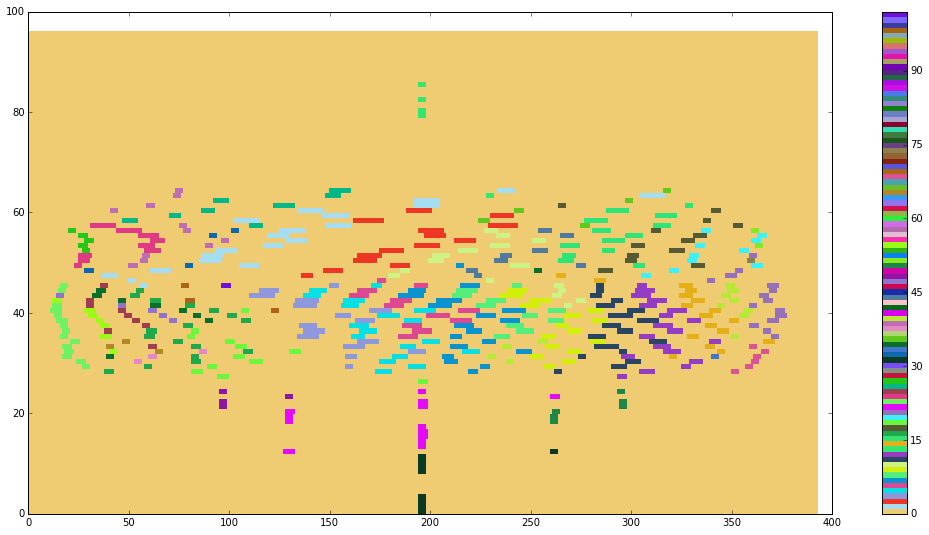

In [11]:
plt.figure(figsize=(18,height/10))
plt.pcolor(c_flow[::-1], cmap=mpl.colors.ListedColormap(np.random.rand(96,3)))
plt.colorbar()
plt.show()

In [377]:
def format_to_d3(communities_input):
    communities_output = {}
    for layer, groups in communities_input().items():
        for no, clu in groups:
            try:
                communities_output[layer].append({"_id": no, "community": clu})
            except KeyError:
                communities_output[layer] = [{"_id": no, "community": clu}]

    return communities

with open('../Visualisation/data/communities_sample.json', 'w') as outfile:
    outfile.write(json.dumps(communities))

{1: [{'_id': 'b9cc2b6d9343893409223155ee7424', 'community': 81},
  {'_id': '67958cabc71d8ad41f3296199309a8', 'community': 42},
  {'_id': 'da8cd4c510d19f837d483beb93638e', 'community': 69},
  {'_id': 'e2b531dd96b79f69ee8399932b5a08', 'community': 44},
  {'_id': 'f5a3832701d7dbcdba3fa74761eccb', 'community': 22},
  {'_id': '61667a742d75951e3dd8125e606c9c', 'community': 23},
  {'_id': '157b03b07c622c8adbc4232b441438', 'community': 34},
  {'_id': 'c67d29cd66bc0b80eae266e200d8a3', 'community': 35},
  {'_id': 'c58969f60280e07662e4ed23008de5', 'community': 22},
  {'_id': '15caec931071ea566748bbf5f0b6a4', 'community': 44},
  {'_id': '03eb449d4c70f8e3ac56103ac73c3b', 'community': 23},
  {'_id': 'cb969ab50a684a4dfe7452013a3d58', 'community': 57},
  {'_id': 'c130d6d1bbb6d17e7089147b62ee52', 'community': 1},
  {'_id': '792b94ad80885c219a53366de477d8', 'community': 79},
  {'_id': 'a86f60d62eaad69ef35e36650fc10b', 'community': 7},
  {'_id': '891da2ff36762eb98e64053824f996', 'community': 50},
  {'_id

In [87]:
aggregate = {}
time_profile = {}
for k,v in layer_communities.items():
    for c, n in v.items():
        try:
            aggregate[c] += len(n)
            time_profile[c].append([k, len(n)])
        except KeyError:
            aggregate[c] = len(n)
            time_profile[c] = [[k, len(n)]]

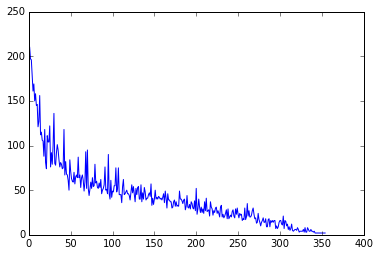

In [88]:
x, y = [], []
for k,v in aggregate.items():
    x.append(k); y.append(v)
plt.plot(x,y); plt.show()

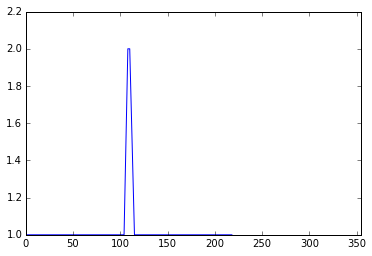

In [89]:
def plot_cluster_time_profile(clu):
    x = []
    y = []
    for k,v in time_profile[clu]:
        x.append(k); y.append(v)
    plt.plot(x,y)
    plt.xlim([0,max(communities.keys())])
    plt.show()
plot_cluster_time_profile(10)

In [197]:
communities

{1: {15: ['533c43f05f863b68dc308280b82820',
   'c130d6d1bbb6d17e7089147b62ee52',
   '673fb69d85e592ba4cbc1349cd998f',
   '7b97a29e7203dc5f32aa8821da2e74',
   '9521d0db4ccaa684c0faddb8bcb60d',
   '7d2a3e1fc0e15fdb40c8dde5c35ebd',
   'cb969ab50a684a4dfe7452013a3d58',
   'e393ffb658343d8ded19dbc2a0569d',
   '4ca7e7159c3873305be35f07cfe438',
   '189b5ff48a2a5ddd241f9587423918',
   '42774ab3885240e894a8b41088f20b',
   '30383e7d47ff768d56639c31ac2664',
   '648a348c89de1523ebcdcb47e7eaf1',
   'e7659834f15dd1cd2f7d1774f40156',
   'd5f7d3e1e9544ad5f0e0b5797bcd26',
   '01eac40da88f4124f77c4bef560296',
   'f34c9ceb22c7f36b3f543f927ead62',
   '3782b301e15c952cbc19c1c98bee8a',
   '946df17c3d8629f1a4212983afdca7',
   '8216b2c7553c9c95b1f7a2c0eaea87',
   '0037c93a19a7e90580086b462ba11b',
   '7a3236d1e82edfb253a0e4060ff64e',
   '88b06b07af9a8c43e3048003324a6c',
   '995a155356ba09745a5fcc786d03a9'],
  24: ['b7b98e1489e735d8ce4d30348efcc9',
   '75e3669e556859f5610a985431264a',
   '15f2df470e3660b75fc769

In [332]:
a = dt.fromtimestamp(month_sho_15mins[192:672]['timestamp'].values[0])

In [333]:
print a
print a.weekday()

2014-02-08 00:05:00
5


In [464]:
def gen_tmp():
    for i in range(19):
        yield i

SyntaxError: 'return' with argument inside generator (<ipython-input-464-8bfed017ec63>, line 4)

In [477]:
tmp = {"nodes":[{"x":444,"y":275},{"x":378,"y":324},{"x":478,"y":278},{"x":471,"y":256},{"x":382,"y":269},{"x":371,"y":247},{"x":359,"y":276},{"x":364,"y":302},{"x":400,"y":330},{"x":388,"y":298},{"x":524,"y":296},{"x":570,"y":243},{"x":552,"y":159},{"x":502,"y":287},{"x":511,"y":313},{"x":513,"y":265},{"x":602,"y":132},{"x":610,"y":90},{"x":592,"y":91},{"x":575,"y":89},{"x":607,"y":73},{"x":591,"y":68},{"x":574,"y":73},{"x":589,"y":149},{"x":620,"y":205},{"x":621,"y":230},{"x":589,"y":234},{"x":602,"y":223},{"x":548,"y":188},{"x":532,"y":196},{"x":548,"y":114},{"x":575,"y":174},{"x":497,"y":250},{"x":576,"y":196},{"x":504,"y":201},{"x":494,"y":186},{"x":482,"y":199},{"x":505,"y":219},{"x":486,"y":216},{"x":590,"y":306},{"x":677,"y":169},{"x":657,"y":258},{"x":667,"y":205},{"x":552,"y":227},{"x":518,"y":173},{"x":473,"y":125},{"x":796,"y":260},{"x":731,"y":272},{"x":642,"y":288},{"x":576,"y":269},{"x":605,"y":187},{"x":559,"y":289},{"x":544,"y":356},{"x":505,"y":365},{"x":579,"y":289},{"x":619,"y":282},{"x":574,"y":329},{"x":664,"y":306},{"x":627,"y":304},{"x":643,"y":327},{"x":664,"y":348},{"x":665,"y":327},{"x":653,"y":317},{"x":650,"y":338},{"x":622,"y":321},{"x":633,"y":338},{"x":647,"y":357},{"x":718,"y":362},{"x":636,"y":240},{"x":640,"y":227},{"x":617,"y":249},{"x":631,"y":254},{"x":566,"y":213},{"x":713,"y":322},{"x":716,"y":298},{"x":666,"y":241},{"x":627,"y":355}],"links":[{"source":1,"target":0},{"source":2,"target":0},{"source":3,"target":0},{"source":3,"target":2},{"source":4,"target":0},{"source":5,"target":0},{"source":6,"target":0},{"source":7,"target":0},{"source":8,"target":0},{"source":9,"target":0},{"source":11,"target":10},{"source":11,"target":3},{"source":11,"target":2},{"source":11,"target":0},{"source":12,"target":11},{"source":13,"target":11},{"source":14,"target":11},{"source":15,"target":11},{"source":17,"target":16},{"source":18,"target":16},{"source":18,"target":17},{"source":19,"target":16},{"source":19,"target":17},{"source":19,"target":18},{"source":20,"target":16},{"source":20,"target":17},{"source":20,"target":18},{"source":20,"target":19},{"source":21,"target":16},{"source":21,"target":17},{"source":21,"target":18},{"source":21,"target":19},{"source":21,"target":20},{"source":22,"target":16},{"source":22,"target":17},{"source":22,"target":18},{"source":22,"target":19},{"source":22,"target":20},{"source":22,"target":21},{"source":23,"target":16},{"source":23,"target":17},{"source":23,"target":18},{"source":23,"target":19},{"source":23,"target":20},{"source":23,"target":21},{"source":23,"target":22},{"source":23,"target":12},{"source":23,"target":11},{"source":24,"target":23},{"source":24,"target":11},{"source":25,"target":24},{"source":25,"target":23},{"source":25,"target":11},{"source":26,"target":24},{"source":26,"target":11},{"source":26,"target":16},{"source":26,"target":25},{"source":27,"target":11},{"source":27,"target":23},{"source":27,"target":25},{"source":27,"target":24},{"source":27,"target":26},{"source":28,"target":11},{"source":28,"target":27},{"source":29,"target":23},{"source":29,"target":27},{"source":29,"target":11},{"source":30,"target":23},{"source":31,"target":30},{"source":31,"target":11},{"source":31,"target":23},{"source":31,"target":27},{"source":32,"target":11},{"source":33,"target":11},{"source":33,"target":27},{"source":34,"target":11},{"source":34,"target":29},{"source":35,"target":11},{"source":35,"target":34},{"source":35,"target":29},{"source":36,"target":34},{"source":36,"target":35},{"source":36,"target":11},{"source":36,"target":29},{"source":37,"target":34},{"source":37,"target":35},{"source":37,"target":36},{"source":37,"target":11},{"source":37,"target":29},{"source":38,"target":34},{"source":38,"target":35},{"source":38,"target":36},{"source":38,"target":37},{"source":38,"target":11},{"source":38,"target":29},{"source":39,"target":25},{"source":40,"target":25},{"source":41,"target":24},{"source":41,"target":25},{"source":42,"target":41},{"source":42,"target":25},{"source":42,"target":24},{"source":43,"target":11},{"source":43,"target":26},{"source":43,"target":27},{"source":44,"target":28},{"source":44,"target":11},{"source":45,"target":28},{"source":47,"target":46},{"source":48,"target":47},{"source":48,"target":25},{"source":48,"target":27},{"source":48,"target":11},{"source":49,"target":26},{"source":49,"target":11},{"source":50,"target":49},{"source":50,"target":24},{"source":51,"target":49},{"source":51,"target":26},{"source":51,"target":11},{"source":52,"target":51},{"source":52,"target":39},{"source":53,"target":51},{"source":54,"target":51},{"source":54,"target":49},{"source":54,"target":26},{"source":55,"target":51},{"source":55,"target":49},{"source":55,"target":39},{"source":55,"target":54},{"source":55,"target":26},{"source":55,"target":11},{"source":55,"target":16},{"source":55,"target":25},{"source":55,"target":41},{"source":55,"target":48},{"source":56,"target":49},{"source":56,"target":55},{"source":57,"target":55},{"source":57,"target":41},{"source":57,"target":48},{"source":58,"target":55},{"source":58,"target":48},{"source":58,"target":27},{"source":58,"target":57},{"source":58,"target":11},{"source":59,"target":58},{"source":59,"target":55},{"source":59,"target":48},{"source":59,"target":57},{"source":60,"target":48},{"source":60,"target":58},{"source":60,"target":59},{"source":61,"target":48},{"source":61,"target":58},{"source":61,"target":60},{"source":61,"target":59},{"source":61,"target":57},{"source":61,"target":55},{"source":62,"target":55},{"source":62,"target":58},{"source":62,"target":59},{"source":62,"target":48},{"source":62,"target":57},{"source":62,"target":41},{"source":62,"target":61},{"source":62,"target":60},{"source":63,"target":59},{"source":63,"target":48},{"source":63,"target":62},{"source":63,"target":57},{"source":63,"target":58},{"source":63,"target":61},{"source":63,"target":60},{"source":63,"target":55},{"source":64,"target":55},{"source":64,"target":62},{"source":64,"target":48},{"source":64,"target":63},{"source":64,"target":58},{"source":64,"target":61},{"source":64,"target":60},{"source":64,"target":59},{"source":64,"target":57},{"source":64,"target":11},{"source":65,"target":63},{"source":65,"target":64},{"source":65,"target":48},{"source":65,"target":62},{"source":65,"target":58},{"source":65,"target":61},{"source":65,"target":60},{"source":65,"target":59},{"source":65,"target":57},{"source":65,"target":55},{"source":66,"target":64},{"source":66,"target":58},{"source":66,"target":59},{"source":66,"target":62},{"source":66,"target":65},{"source":66,"target":48},{"source":66,"target":63},{"source":66,"target":61},{"source":66,"target":60},{"source":67,"target":57},{"source":68,"target":25},{"source":68,"target":11},{"source":68,"target":24},{"source":68,"target":27},{"source":68,"target":48},{"source":68,"target":41},{"source":69,"target":25},{"source":69,"target":68},{"source":69,"target":11},{"source":69,"target":24},{"source":69,"target":27},{"source":69,"target":48},{"source":69,"target":41},{"source":70,"target":25},{"source":70,"target":69},{"source":70,"target":68},{"source":70,"target":11},{"source":70,"target":24},{"source":70,"target":27},{"source":70,"target":41},{"source":70,"target":58},{"source":71,"target":27},{"source":71,"target":69},{"source":71,"target":68},{"source":71,"target":70},{"source":71,"target":11},{"source":71,"target":48},{"source":71,"target":41},{"source":71,"target":25},{"source":72,"target":26},{"source":72,"target":27},{"source":72,"target":11},{"source":73,"target":48},{"source":74,"target":48},{"source":74,"target":73},{"source":75,"target":69},{"source":75,"target":68},{"source":75,"target":25},{"source":75,"target":48},{"source":75,"target":41},{"source":75,"target":70},{"source":75,"target":71},{"source":76,"target":64},{"source":76,"target":65},{"source":76,"target":66},{"source":76,"target":63},{"source":76,"target":62},{"source":76,"target":48},{"source":76,"target":58}]}

In [479]:
tmp

{'links': [{'source': 1, 'target': 0},
  {'source': 2, 'target': 0},
  {'source': 3, 'target': 0},
  {'source': 3, 'target': 2},
  {'source': 4, 'target': 0},
  {'source': 5, 'target': 0},
  {'source': 6, 'target': 0},
  {'source': 7, 'target': 0},
  {'source': 8, 'target': 0},
  {'source': 9, 'target': 0},
  {'source': 11, 'target': 10},
  {'source': 11, 'target': 3},
  {'source': 11, 'target': 2},
  {'source': 11, 'target': 0},
  {'source': 12, 'target': 11},
  {'source': 13, 'target': 11},
  {'source': 14, 'target': 11},
  {'source': 15, 'target': 11},
  {'source': 17, 'target': 16},
  {'source': 18, 'target': 16},
  {'source': 18, 'target': 17},
  {'source': 19, 'target': 16},
  {'source': 19, 'target': 17},
  {'source': 19, 'target': 18},
  {'source': 20, 'target': 16},
  {'source': 20, 'target': 17},
  {'source': 20, 'target': 18},
  {'source': 20, 'target': 19},
  {'source': 21, 'target': 16},
  {'source': 21, 'target': 17},
  {'source': 21, 'target': 18},
  {'source': 21, 'targ